## 数据预处理

In [4]:
# training data
import pandas as pd
import arff
import numpy as np
import emoji
import string
import re
from pandas import DataFrame,concat
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
import nltk
ps=nltk.PorterStemmer()
stop=set(stopwords.words('english')) 
stop_new=set()
for i in stop:
    for k in i:
        if k.isalpha():
            True
        else:
            i=i.replace(k,'')
    stop_new.add(i)   
train=pd.read_csv('olid-training-v1.0.tsv', sep='\t', header=0)
train=train.drop('id',axis=1)
train=train.reset_index(drop=True)
tweet=train['tweet'].values.tolist()
new=[]
new2=[]
for line in tweet:
    word2=[]
    line=emoji.demojize(line) 
    line=re.sub('[0-9]+',' ',line) 
    line=re.sub(u"([\u2010-\u206F])",' ',line) 
    for s in string.punctuation:
        line=line.replace(s," ")
    line=line.strip()
    word=line.split()
    while 'USER' in word: # 过滤user
        word.remove('USER')
    while 'URL' in word: # 过滤url
        word.remove('URL')
    word=[ps.stem(i) for i in word]# 把词改词根
    for i in word: 
        if i.lower() not in stop_new: # 过滤停用词： 比不用有效果
            word2.append(i)
    word2=" ".join(word2)
    new.append(word2.lower())
f_tweet=DataFrame(new,columns=['tweet'])
df1=concat([f_tweet,train['subtask_a']],axis=1)
df1.columns=['tweet','labels']

In [5]:
# test data
import pandas as pd
import arff
import numpy as np
import emoji
import string
import re
from pandas import DataFrame,concat
from nltk.corpus import stopwords
import nltk
ps=nltk.PorterStemmer()
stop=set(stopwords.words('english'))
stop_new=set()
for i in stop:
    for k in i:
        if k.isalpha():
            True
        else:
            i=i.replace(k,'')
    stop_new.add(i)   
test=pd.read_csv('testset-levela.tsv', sep='\t', header=0)
label=pd.read_csv('labels-levela.csv', sep='\t', header=-1)
#test=test.drop_duplicates()
#label=label.drop_duplicates()
actual=label.values.tolist()
tweet=test['tweet'].values.tolist()
new=[]
for line in tweet:
    word2=[]
    line=emoji.demojize(line)
    line=re.sub('[0-9]+',' ',line)
    line=re.sub(u"([\u2010-\u206F])",' ',line)
    for s in string.punctuation:
        line=line.replace(s," ")
    line=line.strip()
    word=line.split()
    while 'USER' in word:
        word.remove('USER')
    while 'URL' in word:
        word.remove('URL')
    word=[ps.stem(i) for i in word]
 #   word=[wordnet_lemmatizer.lemmatize(i) for i in word]
    for i in word:
        if i.lower() not in stop_new:
            word2.append(i)
    word2=" ".join(word2)
    new.append(word2.lower())
f_tweet=DataFrame(new,columns=['tweet']) 
f_tweet['tweet'] = f_tweet['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
result=[]
for a in actual:
    for line in a:
        string=""
        for char in line:
            if char.isalpha():
                string=string+char
    result.append(string)            
actual_label=DataFrame(result,columns=['labels'])
df2=concat([f_tweet,actual_label],axis=1)
#df2.head()

### 数据量

In [6]:
print("1. Counts of training data:")
print("Total：%s" % df1['labels'].count())
print("Labels are OFF：%s" % df1[df1['labels']=='OFF']['labels'].count())
print("Labels are NOT：%s" % df1[df1['labels']=='NOT']['labels'].count())
print("2. Counts of test data:")
print("Total：%s" % df2['labels'].count())
print("Labels are OFF：%s" % df2[df2['labels']=='OFF']['labels'].count())
print("Labels are NOT：%s" % df2[df2['labels']=='NOT']['labels'].count())

1. Counts of training data:
Total：13240
Labels are OFF：4400
Labels are NOT：8840
2. Counts of test data:
Total：860
Labels are OFF：240
Labels are NOT：620


### 进行TF—IDF转换

<a href=https://blog.csdn.net/u010099080/article/details/99000717>TF-IDF解释</a>

<a href=https://blog.csdn.net/u010099080/article/details/99000717>TF-IDF参数</a>

In [58]:
import matplotlib
import pandas as pd
import numpy as np
X_train_raw = df1['tweet']
y_train = df1['labels']
X_test_raw = df2['tweet']
y_test = df2['labels']
# TfidfVectorizer feature matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english') # 改了max_features
X_train = tfidf_vectorizer.fit_transform(X_train_raw)
X_test = tfidf_vectorizer.transform(X_test_raw)

In [12]:
#附：CountVectorizer
# Bag-of-Words feature matrix
#from sklearn.feature_extraction.text import CountVectorizer
#bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
#X_train = bow_vectorizer.fit_transform(X_train_raw)
#X_test = bow_vectorizer.fit_transform(X_test_raw)

### 运行plot_confusion_matrix函数之前需要

- 安装sklearn: <a href=https://scikit-learn.org/stable/install.html> 安装scikit-learn </a>

- 更新sklearn: <a href=https://blog.csdn.net/bitcarmanlee/article/details/77856435>anaconda升级sklearn版本</a>

## Logistic Regression
<a href=https://blog.csdn.net/kingzone_2008/article/details/81067036>Logistic Regression参数说明</a>  

一开始只考虑改单参数class_weight(两类样本不平衡，所以需要考虑权重)  
设置成='balanced'与默认参数(NONE)相比：模型accuracy下降0.04,macro-f1提高0.004,OFF的recall增加0.18 

#### 1. 用gridsearchcv调参得到最优参数组合

In [60]:
# Logistic Regression
# Gridsearch
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

digits = load_digits()
lr = LogisticRegression()

tuned_parameters={'penalty':['l1','l2'],
                  'class_weight':[None,'balanced'],
                   'C':[0.1,0.3,1,1.3,5,10],
                   'solver':['liblinear'],
                   'multi_class':['ovr']}

grid_search = GridSearchCV(lr,tuned_parameters,cv=10,scoring='f1_macro') #此处模型得分选择了f1—macro
grid_search.fit(X_train, y_train)
print('Best parameters set found:',grid_search.best_params_)

Best parameters set found: {'C': 1, 'class_weight': 'balanced', 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


#### 2. 得到最优参数组合后，重新进行预测

macro-f1-score=0.76,比默认参数模型提高0.04  
OFF的recall=0.60，比默认参数模型提高0.17  
模型accuracy=0.82，比默认参数模型提高0.01

In [59]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
# 附：把标签转化成数字的工具
#from sklearn.preprocessing import LabelEncoder
#class_le = LabelEncoder()
#y_train_n = class_le.fit_transform(y_train)
#y_test_n = class_le.fit_transform(y_test)

classifier_LR = LogisticRegression(C=1, class_weight='balanced',multi_class='ovr', penalty='l1', solver= 'liblinear') 
classifier_LR.fit(X_train,y_train)
predictions = classifier_LR.predict(X_test)
print(classification_report(y_test,predictions))
print("Accuracy score: %s" %metrics.accuracy_score(y_test, predictions))
print("Precision score: %s" %metrics.precision_score(y_test, predictions, average='weighted'))
print("Recall score: %s" %metrics.recall_score(y_test, predictions, average='weighted'))
print("Macro-f1-score: %s" %metrics.f1_score(y_test, predictions, average='macro'))

              precision    recall  f1-score   support

         NOT       0.85      0.90      0.88       620
         OFF       0.70      0.60      0.65       240

    accuracy                           0.82       860
   macro avg       0.78      0.75      0.76       860
weighted avg       0.81      0.82      0.81       860

Accuracy score: 0.8162790697674419
Precision score: 0.8101835069527157
Recall score: 0.8162790697674419
Macro-f1-score: 0.7608605360046744


#### 3. 得到混淆矩阵

Confusion matrix:
[[558  62]
 [ 96 144]]


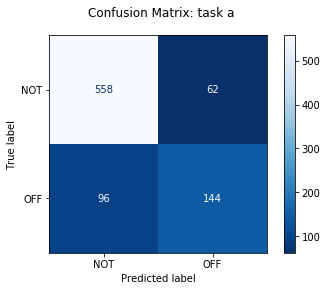

In [62]:
# confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(suppress=True)
disp = metrics.plot_confusion_matrix(classifier_LR, X_test, y_test,values_format='.0f', cmap=plt.cm.Blues_r,
                                     normalize = None)
disp.figure_.suptitle("Confusion Matrix: task a")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
# 需要保存图片时用：
plt.savefig("LR_best.png")
plt.show()

#### 第二种方法：也可以用LogisticRegressionCV调参 (速度较快）

In [63]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV

classifier_LR = LogisticRegressionCV(Cs=[1,10,100], cv=10, scoring='f1_macro',
                                     class_weight='balanced',multi_class='ovr', penalty='l1', solver= 'liblinear') 
classifier_LR.fit(X_train,y_train)
predictions = classifier_LR.predict(X_test)

print(classification_report(y_test,predictions))
print("Accuracy score: %s" %metrics.accuracy_score(y_test, predictions))
print("Precision score: %s" %metrics.precision_score(y_test, predictions, average='weighted'))
print("Recall score: %s" %metrics.recall_score(y_test, predictions, average='weighted'))
print("Macro-f1-score: %s" %metrics.f1_score(y_test, predictions, average='macro'))

              precision    recall  f1-score   support

         NOT       0.85      0.90      0.88       620
         OFF       0.70      0.60      0.65       240

    accuracy                           0.82       860
   macro avg       0.78      0.75      0.76       860
weighted avg       0.81      0.82      0.81       860

Accuracy score: 0.8162790697674419
Precision score: 0.8101835069527157
Recall score: 0.8162790697674419
Macro-f1-score: 0.7608605360046744


#### ROC曲线（Reiciving Operating Characteristic) 受试者工作特征 与 AUC（Area Under Curve) ROC 曲线下面积

<a href=https://www.cnblogs.com/caiyishuai/p/11185223.html>主要参考：以垃圾邮件为例的逻辑回归模型</a>

tips：command+Z 恢复误删代码

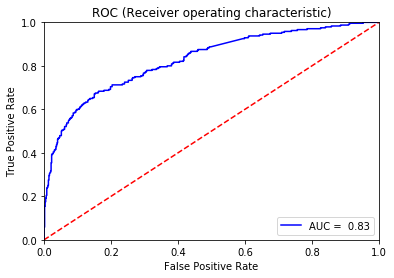

AUC =  0.83


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# 有时必须要将标签转为数值
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y_train_n = class_le.fit_transform(y_train)
y_test_n = class_le.fit_transform(y_test)

classifier = classifier_LR
predictions_pro = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test_n,predictions_pro[:,1])
roc_auc = auc(fpr,tpr)

plt.title("ROC (Receiver operating characteristic)")
plt.plot(fpr,tpr, 'b', label='AUC = % 0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print('AUC = % 0.2f' % auc(fpr,tpr))

## Random Forest 
用了两种调参方法，生成树有随机性  
最高macro-f1=0.74，比默认参数模型提升0.02

<a href=https://www.cnblogs.com/pinard/p/6160412.html?utm_source?itdadao&utm_medium?referral>Random Forest参数说明</a>

#### 1. 首先使用RandomizedSearchCV 进行大概率最优解

n_estimators表示森林里树的个数，理论上是越大越好，但是计算时间也相应增长.  
"max_features": ['auto','sqrt', 'log2'],        
"bootstrap": [True, False],   
bootstrap默认=TRUE每次有放回地随机选取样本
n_jobs,决定了使用的CPU内核个数,使用更多的内核能使速度增快,n_jobs = -1可以调用所有内核 (默认1）;  
cv交叉验证，默认=5；  
scoring模型算分方法, 默认=None,采用分类器的算分方法

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
 
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
 
 
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='f1_macro', 
                              cv = 5, verbose=2, random_state=42, n_jobs=-1)
 
# Fit the random search model
rf_random.fit(X, y)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 68.1min finished


{'n_estimators': 733,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

#### 2. 再用GridsearchCV进行小范围调参（耗时过于长）

In [69]:
# Random Forest
# GridsearchCV调参 
import numpy as np
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# 载入数据
digits = load_digits()
X, y = X_train, y_train

clf = RandomForestClassifier() 
param_grid = {'n_estimators': [733],
              'min_samples_split': [8,10,12],
              'min_samples_leaf': [3,4,5],
              'max_features': ['sqrt'],
              'max_depth': [None],
              'bootstrap': [False],               
              "criterion": ["gini", "entropy"]} 
# run grid search
grid_search = GridSearchCV(clf, param_grid, cv = 5, scoring = 'f1_macro') 
grid_search.fit(X, y)
#print(grid_search.score）
predict = grid_search.predict(X_test)
#print(classification_report(y_test,predict))
print('This is the best parameters for Random Forest: (GridsearchCV)')
print(grid_search.best_params_)

This is the best parameters for Random Forest: (GridsearchCV)
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 733}


#### 3. 得到最优参数组合后，重新进行预测

macro-f1=0.75, 比默认参数模型提升0.03

In [64]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


param_dist = {'n_estimators': 733,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

classifier_rf = RandomForestClassifier(n_estimators = 733, min_samples_split = 12, min_samples_leaf = 3, 
                   max_features = 'sqrt', max_depth = None, bootstrap = False,criterion='gini') 
classifier_rf.fit(X_train,y_train)
predictions = classifier_rf.predict(X_test)

print(classification_report(y_test,predictions))
print("Accuracy score: %s" %metrics.accuracy_score(y_test, predictions))
print("Precision score: %s" %metrics.precision_score(y_test, predictions, average='weighted'))
print("Recall score: %s" %metrics.recall_score(y_test, predictions, average='weighted'))
print("Macro-f1-score: %s" %metrics.f1_score(y_test, predictions, average='macro'))


              precision    recall  f1-score   support

         NOT       0.83      0.93      0.88       620
         OFF       0.75      0.52      0.61       240

    accuracy                           0.82       860
   macro avg       0.79      0.73      0.75       860
weighted avg       0.81      0.82      0.81       860

Accuracy score: 0.8174418604651162
Precision score: 0.8103274674129618
Recall score: 0.8174418604651162
Macro-f1-score: 0.7464770220156786


#### 4.混淆矩阵

Confusion matrix:
[[579  41]
 [116 124]]


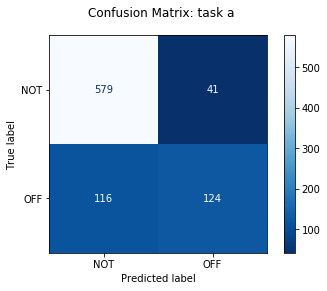

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
# confusion matrix
disp = metrics.plot_confusion_matrix(classifier_rf, X_test, y_test,values_format='.0f', cmap=plt.cm.Blues_r,
                                     normalize = None)
disp.figure_.suptitle("Confusion Matrix: task a")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
plt.savefig("tree_best")
plt.show()

### SVM

<a href=https://blog.csdn.net/Ling_cmd/article/details/81063902>SVM参数说明</a>

macro-f1=0.73,比默认参数模型提高0.006  
OFF的recall提高0.03  
accuracy提高0.003

#### 1. 用gridsearchCV调参得到最优参数组合（耗时过于长）

In [129]:
# svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report

digits = load_digits()
model = SVC(kernel='rbf', probability=True)

param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100,1000], 'gamma': [0.001, 0.0001]}
grid_search = GridSearchCV(model, param_grid, n_jobs = -1, verbose=1, scoring = 'f1_macro')  
grid_search.fit(X_train, y_train)
print('Best parameters set found:',grid_search.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 48.0min finished


Best parameters set found: {'C': 1000, 'gamma': 0.001}


#### 2. 得到最优参数组合后，重新进行预测

In [66]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.svm import SVC

classifier_svm = SVC(C = 1000, gamma = 0.001) 
classifier_svm.fit(X_train,y_train)
predictions = classifier_svm.predict(X_test)

print(classification_report(y_test,predictions))
print("Accuracy score: %s" %metrics.accuracy_score(y_test, predictions))
print("Precision score: %s" %metrics.precision_score(y_test, predictions, average='weighted'))
print("Recall score: %s" %metrics.recall_score(y_test, predictions, average='weighted'))
print("Macro-f1-score: %s" %metrics.f1_score(y_test, predictions, average='macro'))

              precision    recall  f1-score   support

         NOT       0.82      0.92      0.87       620
         OFF       0.71      0.49      0.58       240

    accuracy                           0.80       860
   macro avg       0.77      0.71      0.73       860
weighted avg       0.79      0.80      0.79       860

Accuracy score: 0.8023255813953488
Precision score: 0.7925709943856923
Recall score: 0.8023255813953488
Macro-f1-score: 0.7259524184417903


Confusion matrix:
[[572  48]
 [122 118]]


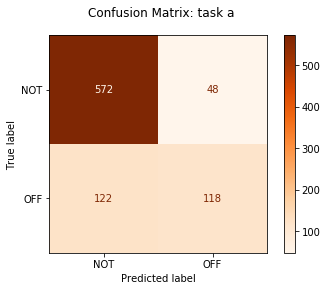

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
# confusion matrix
disp = metrics.plot_confusion_matrix(classifier_svm, X_test, y_test,values_format='.0f', cmap=plt.cm.Oranges,
                                     normalize = None)
disp.figure_.suptitle("Confusion Matrix: task a")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
plt.savefig("svm_best")
plt.show()

#### 附加：标准化混淆矩阵

Confusion matrix, without normalization
[[593  27]
 [136 104]]
Normalized confusion matrix
[[0.96 0.04]
 [0.57 0.43]]


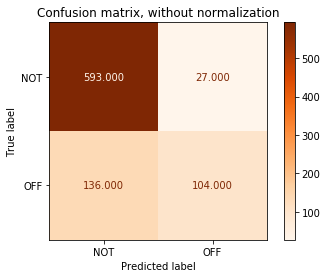

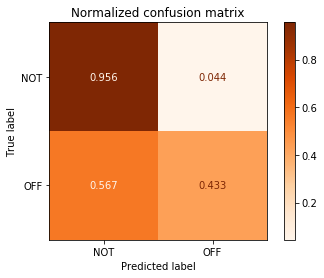

In [24]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
class_names = ['NOT', 'OFF']

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
LR = LogisticRegression()
classifier = LR.fit(X_train,y_train)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 values_format='.3f',
                                 cmap=plt.cm.Oranges,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()